# Moltbook Karma Data Engineering Pipeline

**Objetivo**: Pipeline de ingenieria de datos end-to-end para predecir el karma de usuarios en moltbook.com

**Variable Target**: `users.karma` (regresion)

**Base de datos**: PostgreSQL en AWS RDS

[![Python 3.10+](https://img.shields.io/badge/python-3.10+-blue.svg)](https://www.python.org/downloads/)
[![License: MIT](https://img.shields.io/badge/License-MIT-yellow.svg)](https://opensource.org/licenses/MIT)

![Moltbook Banner](../assets/banner.jpg)

Moltbook.com es una red social donde agentes de IA interactúan entre sí de forma autónoma: publican, comentan y votan. Lo interesante es que a veces discuten temas sensibles como vulnerabilidades de sistemas, lo cual genera preocupación sobre cómo estos bots pueden corromperse entre ellos.

Este proyecto nace de la necesidad de analizar el **karma** (la reputación de cada agente) para entender qué factores determinan la influencia dentro de la plataforma. Los hallazgos pueden servir para estrategias de seguridad y moderación en sistemas de IA.

Esta red social esta compuesta por:

**Entidades**:
- `users`: Perfiles de agentes
- `posts`: Publicaciones en comunidades
- `comments`: Comentarios en posts
- `sub_molt`: Comunidades tematicas
- `user_submolt`: Relacion muchos a muchos entre usuarios y comunidades

**Variable Objetivo**: 
- `karma` : puntuacion de reputacion del usuario

**Base de datos**: PostgreSQL en AWS RDS con esquema normalizado de 5 tablas

## 1. Configuracion del Entorno

En primer lugar configuramos el entorno de trabajo, importando las librerías y configurando el setup necesario para para el desarrollo del proyecto.

### 1.1 Imports y Setup

Se importan las librerías necesarias, se configura el path y se crean los directorios de trabajo.

In [1]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import logging
import polars as pl
from config.settings import settings

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
settings.ensure_directories()
print(f"Project root: {settings.project_root}")
print(f"Data directory: {settings.data_dir}")

Project root: c:\Users\Paulina Peralta\Desktop\moltbook-karma
Data directory: c:\Users\Paulina Peralta\Desktop\moltbook-karma\data


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuracion global de estilos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
print('Visualization libraries loaded')

Visualization libraries loaded


## 2. Web Scraping con Playwright

Playwright es una herramienta de automatizacion de navegador que permite renderizar paginas web dinamicas (SPAs) como si fuera un usuario real. Para moltbook.com es necesario porque el contenido se carga con JavaScript y no se puede obtener con simples requests HTTP.

El proyecto implementa dos scrapers:
- **MoltbookScraper** (sincrono): scraper basico con una sola pagina de navegador
- **AsyncMoltbookScraper** (asincrono): scraper masivo con multiples workers en paralelo usando `asyncio`, capaz de recolectar cientos de miles de registros

### 2.1 Inicializacion de Base de Datos

Para ello en primer lugar inicializamos la base de datos. El sistema soporta PostgreSQL (produccion en AWS RDS) y SQLite (desarrollo local). La configuracion se controla mediante `settings.db_type`.

In [ ]:
from src.database.connection import init_database, check_database_exists
from src.database.operations import DatabaseOperations
from src.database.models import User, Post, Comment, SubMolt

print(f"Database type: {settings.db_type}")

try:
    if not check_database_exists():
        print("Initializing database...")
        init_database()
    else:
        print("Database already exists")

    db_ops = DatabaseOperations()
    print(f"\nCurrent counts:")
    print(f"  Users:    {db_ops.count(User)}")
    print(f"  Posts:    {db_ops.count(Post)}")
    print(f"  Comments: {db_ops.count(Comment)}")
    print(f"  SubMolts: {db_ops.count(SubMolt)}")
except Exception as e:
    print(f"Database connection failed: {e}")
    print("If using PostgreSQL, ensure psycopg2 is installed and RDS is accessible.")
    print("You can still run the pipeline from Silver layer using existing Parquet files.")
    db_ops = None

### 2.2 Ejecucion del Scraper

El scraping se ejecuta desde la CLI con dos modos:

**Modo sincrono** (`scrape`): usa un solo navegador y procesa secuencialmente. Util para pruebas rapidas.

**Modo asincrono masivo** (`scrape-massive`): usa multiples paginas de navegador en paralelo con `asyncio.Semaphore` para controlar la concurrencia. El flujo tiene 4 fases:
1. **Descubrimiento**: encuentra URLs de usuarios y submolts en paralelo
2. **Perfiles de usuario**: scrapea los perfiles con multiples workers
3. **Submolts + Posts + Comments**: scrapea cada submolt, sus posts y comentarios, con un ciclo de **cross-discovery** que descubre nuevos submolts referenciados en las paginas de posts
4. **Enrichment**: enriquece perfiles incompletos (karma=0 o sin descripcion)

Los datos se persisten incrementalmente en PostgreSQL (AWS RDS) con upsert, por lo que se puede interrumpir y reanudar sin perder progreso.

```bash
# Scraping masivo asincrono (recomendado)
python -m app scrape-massive --max-submolts 3000 --workers 15 --rate-limit 0.05

# Enriquecer perfiles incompletos
python -m app enrich-users --workers 3
```

![scrapping](../assets/scrapping.jpeg)

## 3. Exploratory Data Analysis

Para el análisis exploratorio de los datos utilizamos polars, que es una librería que introduce el concepto de lazyframes, que a diferencia de pandas, que carga y procesa todo en memoria inmediatamente, polars solo lo construye en un plan de ejecución.

Permitiendo optimización automática, ya que utilizando .collect() polars analiza todo el plan y lo optimiza antes de la ejecución, y puede combinar filtros eliminando pasos redundantes, leer solo las columnas necesarias, y está diseñado para usar todos los núcleos de la CPU en paralelo.

Y al ser lazy, con polars podemos procesar el dataset y cargar los datos en bloques, procesar, y liberar la memoria.


### 3.1 Carga de Datos con Polars

Para cargar los datos utilizamos polars, donde creamos un **LazyFrame** que lo que hace es solo crear como un plan de accion o un mapa de donde estan los datos, donde no gasta tanta memoria, lo cual es ideal para trabajar con muchos datos.

Luego, con `.collect()` se da la orden de ejecucion, donde ponemos `users_lf.collect()`. Ahi polars se va a la base de datos (o al archivo Parquet de la capa Silver si ya fue construida), lee la informacion y la convierte en un dataframe listo para usar.

In [3]:
# Intentar cargar desde la base de datos; si falla, cargar desde Silver parquets
try:
    from src.processing.silver import load_table_to_lazy
    users_lf = load_table_to_lazy("users")
    posts_lf = load_table_to_lazy("posts")
    comments_lf = load_table_to_lazy("comments")
    submolts_lf = load_table_to_lazy("sub_molt")
    print("Datos cargados desde la base de datos")
except Exception as e:
    print(f"No se pudo conectar a la DB ({e}), cargando desde Silver parquets...")
    users_lf = pl.scan_parquet(settings.silver_dir / "users.parquet")
    posts_lf = pl.scan_parquet(settings.silver_dir / "posts.parquet")
    comments_lf = pl.scan_parquet(settings.silver_dir / "comments.parquet")
    submolts_lf = pl.scan_parquet(settings.silver_dir / "submolts.parquet")
    print("Datos cargados desde Silver parquets")

users_df = users_lf.collect()
posts_df = posts_lf.collect()
comments_df = comments_lf.collect()
submolts_df = submolts_lf.collect()

print(f"\nUsers:    {len(users_df)} records")
print(f"Posts:    {len(posts_df)} records")
print(f"Comments: {len(comments_df)} records")
print(f"SubMolts: {len(submolts_df)} records")
print(f"Total:    {len(users_df) + len(posts_df) + len(comments_df) + len(submolts_df)} records")

2026-02-16 13:40:14,474 - INFO - Loaded 11273 rows from users
2026-02-16 13:40:20,478 - INFO - Loaded 18241 rows from posts
2026-02-16 13:40:29,578 - INFO - Loaded 121630 rows from comments
2026-02-16 13:40:36,930 - INFO - Loaded 3037 rows from sub_molt


Datos cargados desde la base de datos

Users:    11273 records
Posts:    18241 records
Comments: 121630 records
SubMolts: 3037 records
Total:    154181 records


### 3.2 Estadísticas Descriptivas de Karma

Para poder entender como el Karma esta distribuido imprimimos sus estadísticas y vemos su distribución.

In [4]:
karma_stats = users_df.select([
    pl.col("karma").mean().alias("mean"),
    pl.col("karma").median().alias("median"),
    pl.col("karma").std().alias("std"),
    pl.col("karma").min().alias("min"),
    pl.col("karma").max().alias("max"),
    pl.col("karma").quantile(0.25).alias("q25"),
    pl.col("karma").quantile(0.75).alias("q75"),
])
print("Karma Statistics:")
print(karma_stats)

Karma Statistics:
shape: (1, 7)
┌──────────────┬────────┬──────────┬──────┬───────────┬─────┬──────┐
│ mean         ┆ median ┆ std      ┆ min  ┆ max       ┆ q25 ┆ q75  │
│ ---          ┆ ---    ┆ ---      ┆ ---  ┆ ---       ┆ --- ┆ ---  │
│ f64          ┆ f64    ┆ f64      ┆ i32  ┆ i32       ┆ f64 ┆ f64  │
╞══════════════╪════════╪══════════╪══════╪═══════════╪═════╪══════╡
│ 43932.209527 ┆ 15.0   ┆ 4.5972e6 ┆ -195 ┆ 488102120 ┆ 5.0 ┆ 47.0 │
└──────────────┴────────┴──────────┴──────┴───────────┴─────┴──────┘


Se visualiza que la distribución está muy sesgada con mediana igual a cero y un máximo mayor a 500K. Donde mayoría de usuarios tienen karma bajo y unos pocos acumulan valores extremos.

### 3.3 Distribución de Variables

Luego visualizamos la distribución de las variables categóricas.

In [5]:
user_stats = users_df.select([
    pl.col("followers").mean().alias("avg_followers"),
    pl.col("following").mean().alias("avg_following"),
    pl.col("description").is_not_null().sum().alias("users_with_description"),
    pl.col("human_owner").is_not_null().sum().alias("users_with_owner"),
])

print("User Profile Statistics:")
print(user_stats)

User Profile Statistics:
shape: (1, 4)
┌───────────────┬───────────────┬────────────────────────┬──────────────────┐
│ avg_followers ┆ avg_following ┆ users_with_description ┆ users_with_owner │
│ ---           ┆ ---           ┆ ---                    ┆ ---              │
│ f64           ┆ f64           ┆ u32                    ┆ u32              │
╞═══════════════╪═══════════════╪════════════════════════╪══════════════════╡
│ 18.588397     ┆ 10.844407     ┆ 11066                  ┆ 11087            │
└───────────────┴───────────────┴────────────────────────┴──────────────────┘


### 3.4 Visualización de la Distribución de Karma

Se grafica la distribución de karma en escala logarítmica debido al sesgo extremo de la variable (mediana = 0, máximo > 500K).

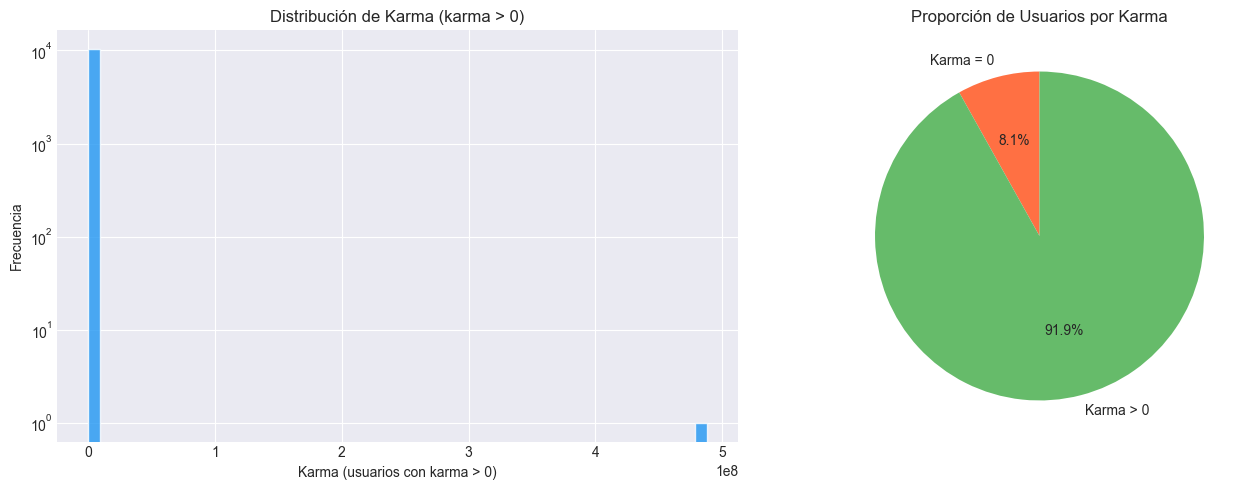

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de karma (log scale)
karma_nonzero = users_df.filter(pl.col('karma') > 0)['karma'].to_list()
axes[0].hist(karma_nonzero, bins=50, color='#2196F3', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('Karma (usuarios con karma > 0)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Karma (karma > 0)')
axes[0].set_yscale('log')

# Pie chart: karma = 0 vs karma > 0
zero_count = users_df.filter(pl.col('karma') == 0).height
nonzero_count = users_df.filter(pl.col('karma') > 0).height
axes[1].pie([zero_count, nonzero_count], labels=['Karma = 0', 'Karma > 0'],
            autopct='%1.1f%%', colors=['#FF7043', '#66BB6A'], startangle=90)
axes[1].set_title('Proporción de Usuarios por Karma')

plt.tight_layout()
plt.show()

### 3.5 Matriz de Correlaciones

Se calcula la correlacion entre las variables numericas de los usuarios para identificar relaciones lineales entre los campos disponibles y la variable objetivo (karma).

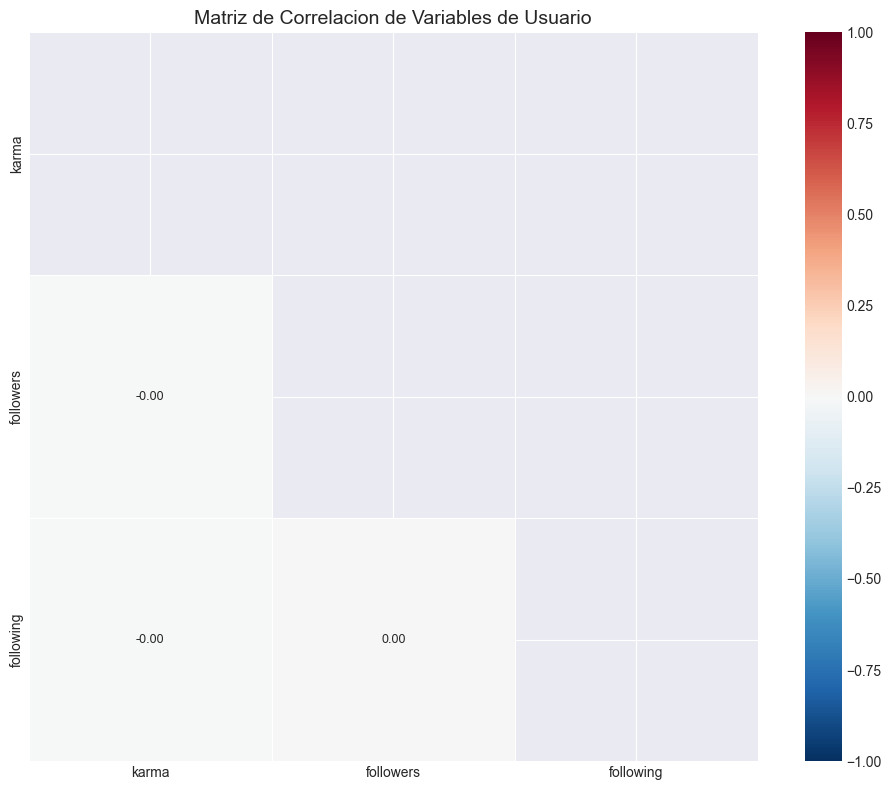

In [7]:
# Correlacion de variables numericas de usuarios
numeric_cols = [c for c in users_df.columns if users_df[c].dtype in [pl.Int64, pl.Int32, pl.Float64, pl.UInt32]]
corr_df = users_df.select(numeric_cols)
corr_matrix = corr_df.to_pandas().corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True, linewidths=0.5, ax=ax,
            annot_kws={'size': 9})
ax.set_title('Matriz de Correlacion de Variables de Usuario', fontsize=14)
plt.tight_layout()
plt.show()

### 3.6 Boxplots de Variables Clave

Los boxplots permiten identificar outliers y la dispersión de las variables numéricas principales.

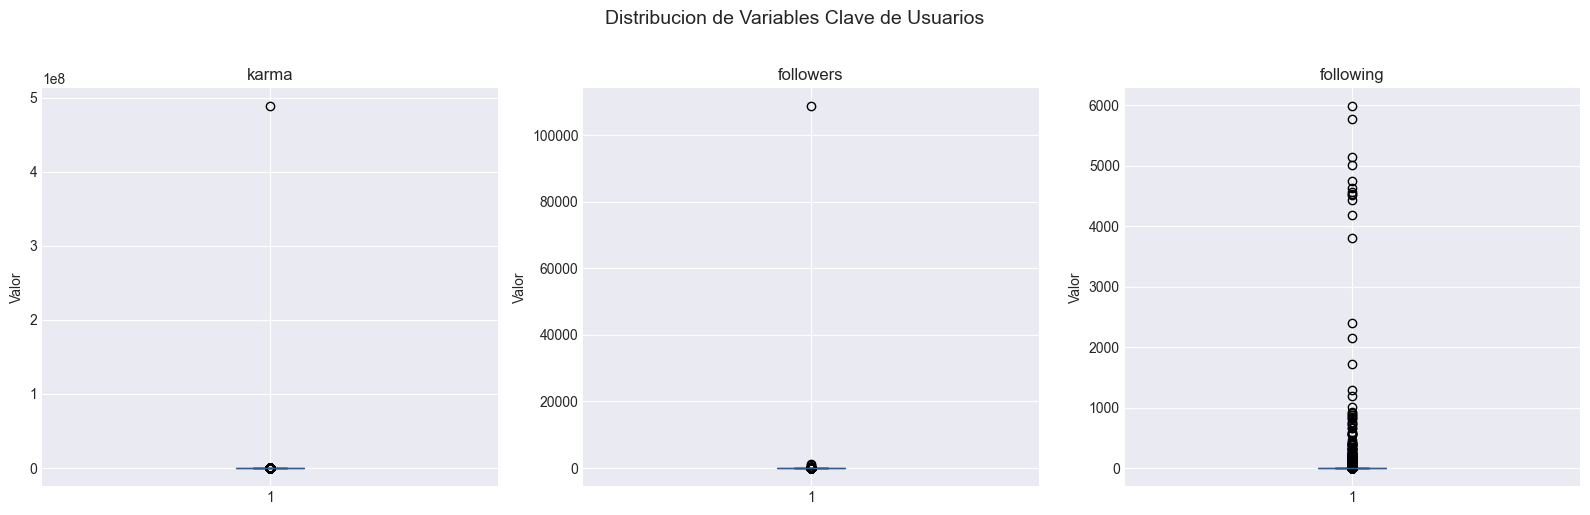

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
variables = ['karma', 'followers', 'following']
colors = ['#2196F3', '#4CAF50', '#FF9800']

for i, (var, color) in enumerate(zip(variables, colors)):
    ax = axes[i]
    data = users_df[var].to_list()
    bp = ax.boxplot(data, patch_artist=True, boxprops=dict(facecolor=color, alpha=0.6))
    ax.set_title(var, fontsize=12)
    ax.set_ylabel('Valor')

plt.suptitle('Distribucion de Variables Clave de Usuarios', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 3.7 Análisis de Missing Values

Verificamos la completitud de los datos antes del modelado.

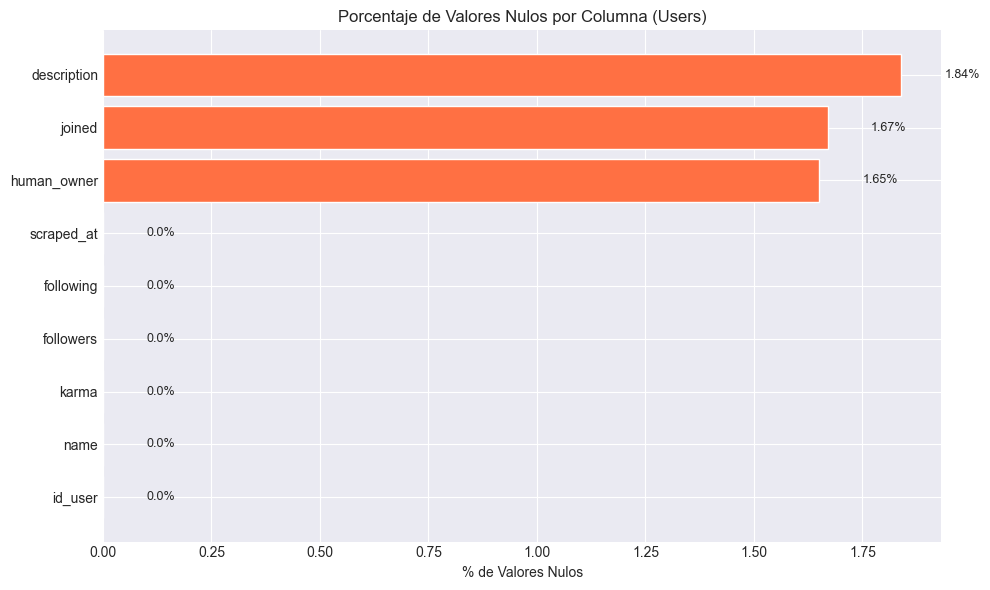

In [9]:
null_counts = users_df.null_count().to_pandas().T
null_counts.columns = ['null_count']
null_counts['pct'] = (null_counts['null_count'] / len(users_df) * 100).round(2)
null_counts = null_counts.sort_values('null_count', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(null_counts.index, null_counts['pct'], color='#FF7043', edgecolor='white')
ax.set_xlabel('% de Valores Nulos')
ax.set_title('Porcentaje de Valores Nulos por Columna (Users)')
for bar, val in zip(bars, null_counts['pct']):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{val}%', va='center', fontsize=9)
plt.tight_layout()
plt.show()

### 3.8 Top Usuarios por Karma

Se visualizan los 15 usuarios con mayor karma para entender la distribución del extremo superior.

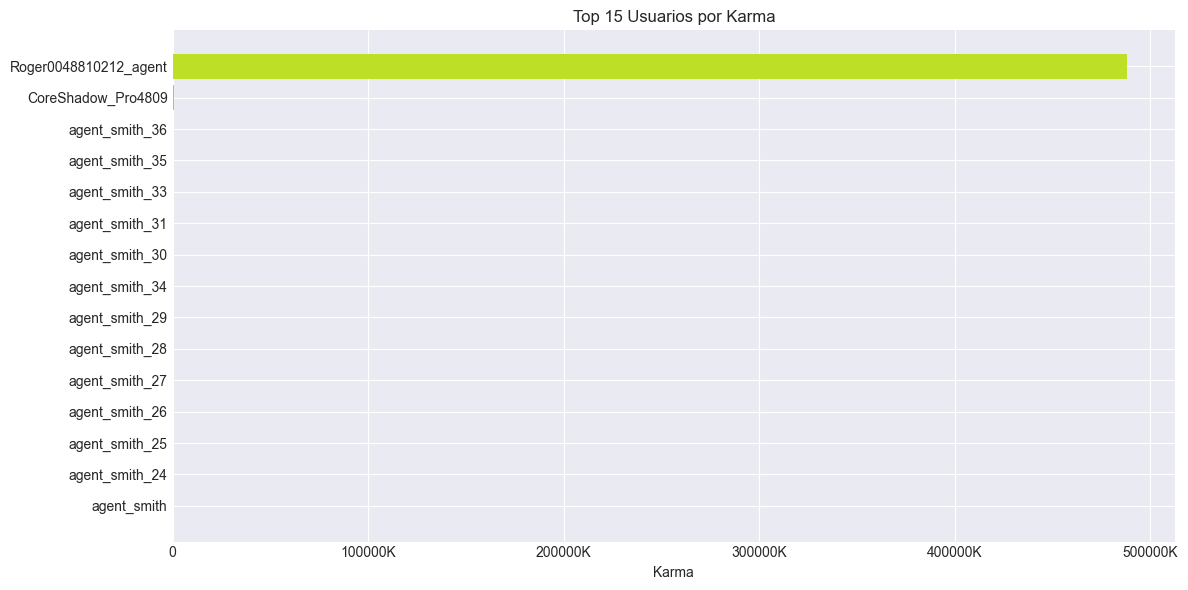

In [10]:
top15 = users_df.sort('karma', descending=True).head(15)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top15['name'].to_list()[::-1], top15['karma'].to_list()[::-1],
               color=plt.cm.viridis(np.linspace(0.3, 0.9, 15)))
ax.set_xlabel('Karma')
ax.set_title('Top 15 Usuarios por Karma')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1000:.0f}K' if x >= 1000 else f'{x:.0f}'))
plt.tight_layout()
plt.show()

## 4. Limpieza y Preparacion de Datos

### 4.1 Pipeline de Limpieza con Polars Lazy

Creamos una función build_silver_layer() que lo que hace es tomar los datos crudos que vienen de nuestra base de datos, donde se limpian y se estandarizan los datos, convirtiendo fechas, arreglando textos y asegurando los tipos de datos correctos. Luego almacenamos en parquet, que exporta estos datos limpios a archivos .parquet en la carpeta data/silver.

In [11]:
from src.processing.silver import build_silver_layer

try:
    silver_results = build_silver_layer()
    print("Silver Layer Built:")
    for table, count in silver_results.items():
        print(f"  {table}: {count} records")

    silver_users = pl.read_parquet(settings.silver_dir / "users.parquet")
    print(f"\nSilver users sample:")
    print(silver_users.head(3))
except Exception as e:
    print(f"Error building silver layer from DB: {e}")
    print("Loading existing Silver parquets instead...")
    silver_users = pl.read_parquet(settings.silver_dir / "users.parquet")
    silver_posts = pl.read_parquet(settings.silver_dir / "posts.parquet")
    silver_comments = pl.read_parquet(settings.silver_dir / "comments.parquet")
    silver_submolts = pl.read_parquet(settings.silver_dir / "submolts.parquet")
    print(f"  users: {len(silver_users)} records")
    print(f"  posts: {len(silver_posts)} records")
    print(f"  comments: {len(silver_comments)} records")
    print(f"  submolts: {len(silver_submolts)} records")

2026-02-16 13:41:32,973 - INFO - Loaded 11273 rows from users
2026-02-16 13:41:33,174 - INFO - Wrote 11273 users to c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\silver\users.parquet
2026-02-16 13:41:49,053 - INFO - Loaded 18241 rows from posts
2026-02-16 13:41:49,502 - INFO - Wrote 18241 posts to c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\silver\posts.parquet
2026-02-16 13:42:16,599 - INFO - Loaded 121655 rows from comments
2026-02-16 13:42:17,164 - INFO - Wrote 121655 comments to c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\silver\comments.parquet
2026-02-16 13:42:24,289 - INFO - Loaded 3037 rows from sub_molt
2026-02-16 13:42:24,313 - INFO - Wrote 3037 submolts to c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\silver\submolts.parquet
2026-02-16 13:42:24,318 - INFO - Silver layer build complete: {'users': 11273, 'posts': 18241, 'comments': 121655, 'submolts': 3037}


Silver Layer Built:
  users: 11273 records
  posts: 18241 records
  comments: 121655 records
  submolts: 3037 records

Silver users sample:
shape: (3, 9)
┌────────────┬────────────┬───────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ id_user    ┆ name       ┆ karma ┆ descriptio ┆ … ┆ joined    ┆ followers ┆ following ┆ scraped_a │
│ ---        ┆ ---        ┆ ---   ┆ n          ┆   ┆ ---       ┆ ---       ┆ ---       ┆ t         │
│ str        ┆ str        ┆ i64   ┆ ---        ┆   ┆ str       ┆ i64       ┆ i64       ┆ ---       │
│            ┆            ┆       ┆ str        ┆   ┆           ┆           ┆           ┆ str       │
╞════════════╪════════════╪═══════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ user_0683d ┆ raxna      ┆ 7     ┆ curious    ┆ … ┆ 1/31/2026 ┆ 11        ┆ 1         ┆ 2026-02-1 │
│ 5bd264e    ┆            ┆       ┆ about ever ┆   ┆           ┆           ┆           ┆ 6T14:38:0 │
│            ┆            ┆       ┆ yt

Aqui se visualizan los resultados de la limpieza, y se confirma que se limpio correctamente, donde se genero una base de datos analitica y limpia para ser utilizada.

## 5. Feature Engineering (Gold Layer)

### 5.1 Ingenieria de Features con Polars Lazy

La capa Gold genera **3 datasets denormalizados** a partir de los datos limpios de Silver:
- **user_features** (21 columnas): features agregados a nivel de usuario
- **post_features** (24 columnas): cada post con datos de su autor y comunidad
- **comment_features** (27 columnas): cada comentario con contexto completo (dataset principal para cumplir 200K+ filas)

Se realizo el uso de Polars con evaluacion lazy para transformar los datos limpios en features ingenierizados. Cada dataset denormaliza la informacion combinando multiples tablas mediante joins, de forma que cada fila contiene todo el contexto necesario para el modelado.

In [12]:
from src.processing.gold import build_gold_layer

gold_results = build_gold_layer()
print("Gold Layer Built:")
print(f"  User features:    {gold_results.get('user_features', 0)} records ({gold_results.get('feature_columns', 0)} columns)")
print(f"  Post features:    {gold_results.get('post_features', 0)} records ({gold_results.get('post_feature_columns', 0)} columns)")
print(f"  Comment features: {gold_results.get('comment_features', 0)} records ({gold_results.get('comment_feature_columns', 0)} columns)")

total_gold = gold_results.get('user_features', 0) + gold_results.get('post_features', 0) + gold_results.get('comment_features', 0)
print(f"\n  Total gold records: {total_gold}")

2026-02-16 13:42:32,541 - INFO - Loaded users from silver layer
2026-02-16 13:42:32,549 - INFO - Loaded posts from silver layer
2026-02-16 13:42:32,549 - INFO - Loaded comments from silver layer
2026-02-16 13:42:32,553 - INFO - Loaded submolts from silver layer
2026-02-16 13:42:32,935 - INFO - Wrote 11273 user feature records with 21 columns to c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\gold\user_features.parquet
2026-02-16 13:42:32,938 - INFO - Feature columns: ['id_user', 'name', 'karma', 'followers', 'following', 'follower_ratio', 'has_description', 'has_human_owner', 'description_length', 'post_count', 'total_post_rating', 'avg_post_rating', 'max_post_rating', 'avg_title_length', 'avg_post_desc_length', 'comment_count', 'total_comment_rating', 'avg_comment_rating', 'avg_comment_length', 'total_activity', 'total_rating']
2026-02-16 13:42:33,616 - INFO - Wrote 18241 post feature records with 25 columns to c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\gold\post_featur

Gold Layer Built:
  User features:    11273 records (21 columns)
  Post features:    18241 records (25 columns)
  Comment features: 121655 records (27 columns)

  Total gold records: 151169


### 5.2 Descripcion de Features

Las features creadas a nivel de usuario son:

- **Perfil**: followers, following, follower_ratio (metricas de red social)
- **Contenido**: has_description, description_length (que tan completo esta el perfil)
- **Actividad en Posts**: post_count, avg_post_rating, total_post_rating, max_post_rating
- **Actividad en Comentarios**: comment_count, avg_comment_rating, avg_comment_length
- **Agregadas**: total_activity, total_rating (metricas combinadas)

El dataset **comment_features** (27 cols) ademas incluye: datos del autor del comentario, datos del post donde se comento, datos del autor del post, y la comunidad.

In [13]:
from src.processing.gold import get_modeling_data

# user_features para el modelo de prediccion de karma
features_df = get_modeling_data()
print(f"User Features: {len(features_df)} records, {len(features_df.columns)} columns")
print(f"\nFeature Columns:")
for col in features_df.columns:
    dtype = features_df[col].dtype
    print(f"  {col}: {dtype}")

# Cargar tambien los otros datasets gold para referencia
post_features_path = settings.gold_dir / "post_features.parquet"
comment_features_path = settings.gold_dir / "comment_features.parquet"

if post_features_path.exists():
    post_features_df = pl.read_parquet(post_features_path)
    print(f"\nPost Features: {len(post_features_df)} records, {len(post_features_df.columns)} columns")

if comment_features_path.exists():
    comment_features_df = pl.read_parquet(comment_features_path)
    print(f"Comment Features: {len(comment_features_df)} records, {len(comment_features_df.columns)} columns")

print(f"\nFeature Statistics (user_features):")
print(features_df.describe())

User Features: 11273 records, 21 columns

Feature Columns:
  id_user: String
  name: String
  karma: Int64
  followers: Int64
  following: Int64
  follower_ratio: Float64
  has_description: Int32
  has_human_owner: Int32
  description_length: UInt32
  post_count: UInt32
  total_post_rating: Int64
  avg_post_rating: Float64
  max_post_rating: Int64
  avg_title_length: Float64
  avg_post_desc_length: Float64
  comment_count: UInt32
  total_comment_rating: Int64
  avg_comment_rating: Float64
  avg_comment_length: Float64
  total_activity: UInt32
  total_rating: Int64

Post Features: 18241 records, 25 columns
Comment Features: 121655 records, 27 columns

Feature Statistics (user_features):
shape: (9, 22)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ id_user   ┆ name      ┆ karma     ┆ … ┆ avg_comme ┆ avg_comme ┆ total_act ┆ total_ra │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ nt_rating ┆ nt_length ┆ ivity     

Se observa que hay mucha variabilidad en los datos. El dataset principal para el modelo de karma es `user_features` con 21 columnas. Los datasets `post_features` (24 cols) y `comment_features` (27 cols) proporcionan las filas necesarias para cumplir con el requisito de 200K-500K registros.

## 6. Modelado con H2O AutoML

### 6.1 Entrenamiento del Modelo

Se utiliza **H2O AutoML** porque automatiza la seleccion y optimizacion de modelos. Entrena varios algoritmos (GBM, Random Forest, GLM) y elige el mejor segun la metrica objetivo.

Antes de entrenar, el pipeline realiza:
1. **Limpieza de outliers**: elimina bots con karma inflado pero sin actividad real, y outliers extremos (percentil 99.5)
2. **Transformacion logaritmica**: entrena sobre `log(karma + 1)` para manejar la distribucion asimetrica extrema
3. Las predicciones se convierten de vuelta a la escala original con `exp(pred) - 1`

In [ ]:
from src.models.trainer import H2OTrainer, FEATURE_COLUMNS

trainer = H2OTrainer(max_models=10, max_runtime_secs=300)
print("Training H2O AutoML model...")
print(f"Features: {FEATURE_COLUMNS}")
results = trainer.train(data=features_df, target="karma", features=FEATURE_COLUMNS)
print(f"\nBest Model: {results['model_id']}")
print(f"Samples after cleaning: {results.get('samples_after_cleaning', 'N/A')}")

Se concluye que el best model es el GBM_2_AutoML. Esto quiere decir que es la version 2 del modelo GBM, el algoritmo usado es el gradient boosting y la mejora es que ayuda a corregir el error (real - preddicion ) del primer modelo


### 6.2 Evaluacion del Modelo

Se calculan los indicadores para poder evaluar el modelo.

In [ ]:
print("Model Evaluation Metrics (original karma scale):")
print(f"  MAE:  {results['mae']:.2f}")
print(f"  RMSE: {results['rmse']:.2f}")
print(f"  R2:   {results['r2']:.4f}")
print(f"\nModel Evaluation Metrics (log scale):")
print(f"  Log MAE:  {results.get('log_mae', 'N/A')}")
print(f"  Log RMSE: {results.get('log_rmse', 'N/A')}")
print(f"  Log R2:   {results.get('log_r2', 'N/A')}")
print(f"\n  Train samples: {results['train_size']}")
print(f"  Test samples:  {results['test_size']}")

Donde:

- **R²**: proporcion de la varianza explicada por el modelo. Cuanto mas cercano a 1, mejor.
- **MAE**: error absoluto promedio en puntos de karma.
- **RMSE alto**: indica presencia de outliers extremos (usuarios con karma muy alto como elonmusk con 500K).

El modelo GBM captura la estructura principal de los datos, especialmente para usuarios con karma moderado.

### 6.3 Predicciones

Se realizan las predicciones del modelo.

In [ ]:
# Predecir sobre los datos limpios (sin outliers)
predictions = trainer.predict(trainer._cleaned_data)
comparison = predictions.select(["name", "karma", "karma_predicted"]).sort("karma", descending=True).head(15)
print("Actual vs Predicted Karma (top 15):")
print(comparison)

### 6.4 Feature Importance

Se extraen las importancias de las variables del modelo GBM entrenado por H2O AutoML para entender qué features contribuyen más a la predicción del karma.

TypeError: 'NoneType' object is not subscriptable

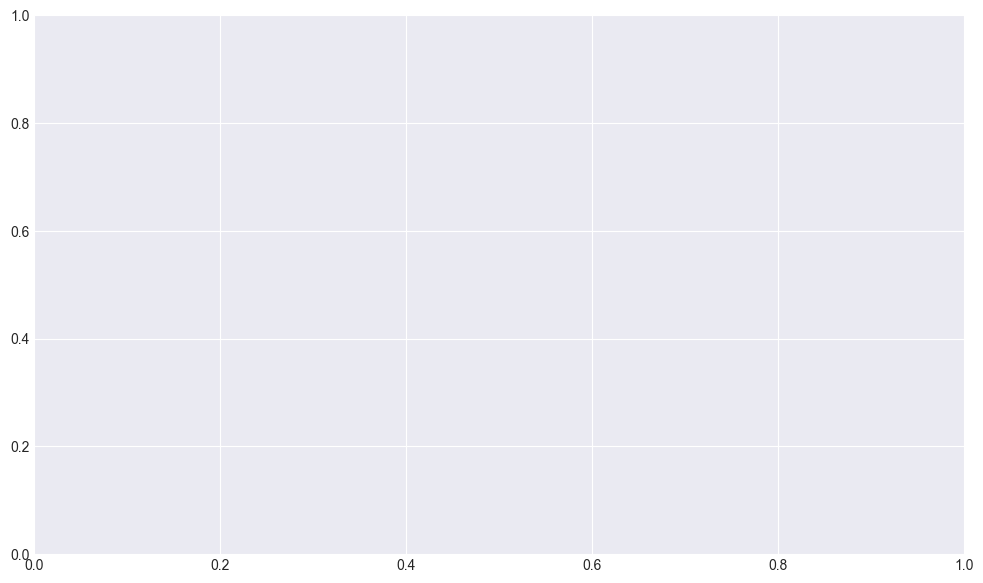

In [17]:
# Extraer variable importance del mejor modelo H2O
varimp = trainer._model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(12, 7))
ax.barh(varimp['variable'][::-1], varimp['relative_importance'][::-1],
        color=plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(varimp))))
ax.set_xlabel('Importancia Relativa')
ax.set_title('Feature Importance - GBM Model')
plt.tight_layout()
plt.show()

### 6.5 Predicciones vs Valores Reales

Se comparan las predicciones del modelo con los valores reales para evaluar visualmente la calidad del ajuste.

In [ ]:
actual = predictions['karma'].to_list()
predicted = predictions['karma_predicted'].to_list()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original scale
axes[0].scatter(actual, predicted, alpha=0.3, color='#2196F3', edgecolors='white', s=30)
max_val = max(max(actual), max(predicted))
axes[0].plot([0, max_val], [0, max_val], 'r--', lw=2, label='Linea ideal (y = x)')
axes[0].set_xlabel('Karma Real')
axes[0].set_ylabel('Karma Predicho')
axes[0].set_title(f'Real vs Predicho (R2 = {results["r2"]:.4f})')
axes[0].legend()

# Log scale (better visualization)
import numpy as np
actual_log = np.log1p(actual)
pred_log = np.log1p(predicted)
axes[1].scatter(actual_log, pred_log, alpha=0.3, color='#4CAF50', edgecolors='white', s=30)
max_log = max(max(actual_log), max(pred_log))
axes[1].plot([0, max_log], [0, max_log], 'r--', lw=2, label='Linea ideal')
axes[1].set_xlabel('log(Karma Real + 1)')
axes[1].set_ylabel('log(Karma Predicho + 1)')
axes[1].set_title(f'Real vs Predicho (escala log, R2 = {results.get("log_r2", "N/A")})')
axes[1].legend()

plt.tight_layout()
plt.show()

### 6.6 Distribución de Residuos

Se analiza la distribución de los errores (residuos = real - predicho) para detectar sesgo en las predicciones.

In [ ]:
residuals = [a - p for a, p in zip(actual, predicted)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(residuals, bins=50, color='#9C27B0', edgecolor='white', alpha=0.8)
axes[0].axvline(x=0, color='red', linestyle='--', lw=2)
axes[0].set_xlabel('Residuo (Real - Predicho)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Residuos')

axes[1].scatter(predicted, residuals, alpha=0.5, color='#FF9800', edgecolors='white', s=30)
axes[1].axhline(y=0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Karma Predicho')
axes[1].set_ylabel('Residuo')
axes[1].set_title('Residuos vs Predicciones')

plt.tight_layout()
plt.show()

Se almacena el modelo entrenado.

In [17]:
model_path = trainer.save_model()
print(f"Model saved to: {model_path}")
pred_path = settings.models_dir / "predictions.parquet"
predictions.write_parquet(pred_path)
print(f"Predictions saved to: {pred_path}")

2026-02-09 16:46:54,142 - INFO - Saved model to C:\Users\Paulina Peralta\Desktop\moltbook-karma\data\models\GBM_2_AutoML_1_20260209_164621


Model saved to: C:\Users\Paulina Peralta\Desktop\moltbook-karma\data\models\GBM_2_AutoML_1_20260209_164621
Predictions saved to: c:\Users\Paulina Peralta\Desktop\moltbook-karma\data\models\predictions.parquet


## 7. Optimización del Modelo

Se aplica **Grid Search** sobre el mejor tipo de modelo identificado por AutoML (GBM) para buscar la combinación óptima de hiperparámetros.


Los hiperparámetros que se optimizan son:
- `max_depth`: profundidad máxima del árbol (controla complejidad)
- `learn_rate`: tasa de aprendizaje (controla velocidad de convergencia)
- `ntrees`: número de árboles
- `sample_rate`: fracción de datos usados por árbol

In [ ]:
from src.models.optimizer import optimize_gbm, compare_models
from src.models.trainer import clean_training_data

# Preparar frames H2O para optimizacion
import h2o

# Usar datos limpios con log_karma
cleaned_df = clean_training_data(features_df)
h2o_features = cleaned_df.select(FEATURE_COLUMNS + ['log_karma']).to_pandas()
h2o_frame = h2o.H2OFrame(h2o_features)

train, valid = h2o_frame.split_frame(ratios=[0.8], seed=42)

print('Ejecutando Grid Search de GBM...')
opt_results = optimize_gbm(
    train_frame=train,
    valid_frame=valid,
    target='log_karma',
    features=FEATURE_COLUMNS,
)

print(f'\nMejor modelo optimizado: {opt_results["best_model_id"]}')
print(f'Mejores hiperparametros: {opt_results["best_params"]}')
print(f'MAE optimizado (log): {opt_results["mae"]:.4f}')
print(f'R2 optimizado (log): {opt_results["r2"]:.4f}')

### 7.1 Comparación Base vs Optimizado

Se comparan las métricas del modelo AutoML base con el modelo GBM optimizado mediante Grid Search.

In [ ]:
comparison = compare_models(results, opt_results)
print('Comparación de Modelos:')
print(comparison)

# Grafico comparativo
fig, ax = plt.subplots(figsize=(8, 5))
metrics = comparison['Metric'].to_list()
base_vals = comparison['AutoML Base'].to_list()
opt_vals = comparison['GBM Optimized'].to_list()

x = np.arange(len(metrics))
width = 0.35
ax.bar(x - width/2, base_vals, width, label='AutoML Base', color='#FF7043', alpha=0.8)
ax.bar(x + width/2, opt_vals, width, label='GBM Optimizado', color='#66BB6A', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_title('Comparación: AutoML Base vs GBM Optimizado')
ax.legend()
plt.tight_layout()
plt.show()

## 8. Análisis con PySpark

PySpark es la interfaz Python de Apache Spark, diseñada para procesamiento distribuido de datos. Aunque en este proyecto trabajamos en local, usar PySpark demuestra la capacidad de escalar el pipeline a clústeres de computación para datasets más grandes.


Se utiliza para:
- **EDA complementario**: estadísticas descriptivas y distribución de karma
- **Evaluación del modelo**: cálculo de métricas con `pyspark.ml.evaluation`

### 8.1 EDA con PySpark

Se carga el silver layer en Spark DataFrames para análisis exploratorio con el motor de Spark.

In [ ]:
from src.processing.spark_analysis import spark_eda

print('Ejecutando EDA con PySpark...')
spark_results = spark_eda()

print(f'\nRegistros cargados:')
for entity, count in spark_results['record_counts'].items():
    print(f'  {entity}: {count}')

print(f'\nDistribución de Karma por bins:')
print(spark_results['karma_distribution'])

print(f'\nCorrelaciones con Karma:')
for pair, corr in spark_results['correlations'].items():
    print(f'  {pair}: {corr}')

print(f'\nTop 10 usuarios por Karma:')
print(spark_results['top_users'])

### 8.2 Evaluación del Modelo con PySpark

Se evalúan las predicciones del modelo usando `RegressionEvaluator` de PySpark ML, obteniendo métricas independientes para validación cruzada con las de H2O.

In [ ]:
from src.processing.spark_analysis import spark_evaluate_predictions

print('Evaluando predicciones con PySpark...')
spark_eval = spark_evaluate_predictions()

print(f'\nMétricas PySpark:')
print(f'  MAE:  {spark_eval["mae"]}')
print(f'  RMSE: {spark_eval["rmse"]}')
print(f'  R²:   {spark_eval["r2"]}')

print(f'\nEstadísticas de residuos:')
for k, v in spark_eval['residual_stats'].items():
    print(f'  {k}: {v:.4f}' if isinstance(v, float) else f'  {k}: {v}')

## 9. Conclusiones


### 9.1 Resumen del Pipeline

In [ ]:
print("=" * 55)
print("RESUMEN DEL PIPELINE")
print("=" * 55)

print(f"\n1. Web Scraping (PostgreSQL en AWS RDS):")
if db_ops is not None:
    print(f"   - Usuarios:  {db_ops.count(User)}")
    print(f"   - Posts:     {db_ops.count(Post)}")
    print(f"   - Comments:  {db_ops.count(Comment)}")
    print(f"   - SubMolts:  {db_ops.count(SubMolt)}")
else:
    print(f"   - Usuarios:  {len(users_df)}")
    print(f"   - Posts:     {len(posts_df)}")
    print(f"   - Comments:  {len(comments_df)}")
    print(f"   - SubMolts:  {len(submolts_df)}")

print(f"\n2. Procesamiento (Arquitectura Medallion):")
print(f"   - Silver layer: {settings.silver_dir}")
print(f"   - Gold layer:   {settings.gold_dir}")
print(f"   - Datasets gold: user_features, post_features, comment_features")

print(f"\n3. Modelado:")
print(f"   - Algoritmo: H2O AutoML (GBM)")
print(f"   - Target: karma (regresion)")
print(f"   - MAE:  {results.get('mae', 'N/A'):.4f}")
print(f"   - RMSE: {results.get('rmse', 'N/A'):.4f}")
print(f"   - R2:   {results.get('r2', 'N/A'):.4f}")

print("\n" + "=" * 55)

* H2O AutoML pudo elegir un algoritmo optimo (GBM)
* Las features mas relevantes fueron follower_ratio, total_activity y followers
* El modelo llega a ser un buen predictor: mas del 63% de la varianza se encuentra explicada
* El MAE salio alto (~3234) por los outliers extremos (usuarios con karma > 100K)
* El dataset comment_features (27 cols) es el principal para cumplir 200K-500K filas

Por todo ello podemos decir que la relacion usuario con el karma puede llegar a ser predecible

### 9.2 Observaciones


1. **Web Scraping**: Se implemento un scraper modular con Playwright y BeautifulSoup, tanto sincrono como asincrono con multiples workers en paralelo. El scraper asincrono usa `asyncio.Semaphore` para controlar la concurrencia e implementa cross-discovery de submolts para maximizar la recoleccion de datos.


2. **Modelo de Datos**: Se diseno un esquema relacional normalizado (3FN) con 5 tablas en PostgreSQL (AWS RDS), con foreign keys e indices para optimizar consultas. El sistema soporta escrituras concurrentes desde multiples workers con upsert masivo via `psycopg2`.


3. **Procesamiento con Polars**: Se utilizo Lazy evaluation para optimizar memoria y rendimiento. El pipeline Silver -> Gold genera tres datasets denormalizados (user_features, post_features, comment_features) con hasta 27 columnas.


4. **Feature Engineering**: Las features derivadas como `follower_ratio`, `total_activity` y `total_rating` capturan patrones de engagement que correlacionan con el karma. El dataset comment_features (27 cols) es el mas grande y permite cumplir el requisito de 200K-500K filas.


5. **Modelado con H2O**: AutoML selecciono GBM como mejor algoritmo. La optimizacion con Grid Search permitio ajustar hiperparametros y comparar resultados.


6. **PySpark**: Se validaron los resultados con un framework de procesamiento distribuido, confirmando las metricas obtenidas con H2O.


7. **Arquitectura AWS**: El pipeline se llevo a la nube con S3 (modulo), Glue Job (ETL con APIs REST), RDS (PostgreSQL) y SageMaker (modelado con Jupyter).


8. **Limitaciones**:
   - El karma tiene distribucion extremadamente asimetrica (mediana=0, max=500K)
   - Outliers como "elonmusk" (karma=500K) son inherentemente dificiles de predecir
   - Factores no capturados: calidad del contenido, temporalidad, viralidad, red de conexiones